In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [33]:
#path = "data/ml-20m/"
path = "data/ml-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [34]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [35]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [36]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [37]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [38]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [39]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [40]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [41]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [42]:
n_factors = 50

In [43]:
np.random.seed = 42

Randomly split into training and validation.

In [44]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [76]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [78]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [80]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [81]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [82]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [23]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [24]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [25]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80010 samples, validate on 19994 samples
Epoch 1/1
80010/80010 [==============================] - 1s - loss: 9.8328 - val_loss: 3.7591


In [26]:
model.optimizer.lr=0.01

In [27]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80010 samples, validate on 19994 samples
Epoch 1/3
80010/80010 [==============================] - 2s - loss: 3.1172 - val_loss: 2.0018
Epoch 2/3
80010/80010 [==============================] - 1s - loss: 2.4130 - val_loss: 1.6529
Epoch 3/3
80010/80010 [==============================] - 1s - loss: 2.2526 - val_loss: 1.5249


In [28]:
model.optimizer.lr=0.001

In [29]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80010 samples, validate on 19994 samples
Epoch 1/6
80010/80010 [==============================] - 1s - loss: 2.1931 - val_loss: 1.4808
Epoch 2/6
80010/80010 [==============================] - 1s - loss: 2.1621 - val_loss: 1.4582
Epoch 3/6
80010/80010 [==============================] - 1s - loss: 2.1386 - val_loss: 1.4439
Epoch 4/6
80010/80010 [==============================] - 1s - loss: 2.1143 - val_loss: 1.4423
Epoch 5/6
80010/80010 [==============================] - 1s - loss: 2.0909 - val_loss: 1.4441
Epoch 6/6
80010/80010 [==============================] - 1s - loss: 2.0673 - val_loss: 1.4457


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [45]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [46]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [47]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [48]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [49]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [418]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

In [419]:
model.optimizer.lr=0.01

In [420]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

In [421]:
model.optimizer.lr=0.001

In [422]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

In [248]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79838 samples, validate on 20166 samples
Epoch 1/5
79838/79838 [==============================] - 2s - loss: 0.6237 - val_loss: 0.8030
Epoch 2/5
79838/79838 [==============================] - 2s - loss: 0.6084 - val_loss: 0.8016
Epoch 3/5
79838/79838 [==============================] - 2s - loss: 0.5950 - val_loss: 0.8004
Epoch 4/5
79838/79838 [==============================] - 2s - loss: 0.5844 - val_loss: 0.7981
Epoch 5/5
79838/79838 [==============================] - 2s - loss: 0.5747 - val_loss: 0.7979


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [100]:
model.save_weights(model_path+'bias.h5')

In [50]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [54]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.8307]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [56]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [57]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [23]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.80693638, 'Battlefield Earth (2000)'),
 (-0.52972311, 'Spice World (1997)'),
 (-0.44621521, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.44280463, 'Super Mario Bros. (1993)'),
 (-0.44120365, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.43341145, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (-0.41436779, 'Howard the Duck (1986)'),
 (-0.39790833, 'Blade: Trinity (2004)'),
 (-0.36255124, 'Jaws 3-D (1983)'),
 (-0.2954753, 'Speed 2: Cruise Control (1997)'),
 (-0.22500136, 'Scooby-Doo (2002)'),
 (-0.19756798,
  'Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994)'),
 (-0.19622488, 'Honey, I Blew Up the Kid (1992)'),
 (-0.17063878, 'Police Academy 6: City Under Siege (1989)'),
 (-0.16920321, 'Wild Wild West (1999)')]

In [24]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.7250408, 'Little Big Man (1970)'),
 (1.7194961, 'Shawshank Redemption, The (1994)'),
 (1.7044764, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.7008729, 'Mister Roberts (1955)'),
 (1.6823107, 'Persuasion (1995)'),
 (1.6384603, 'Godfather, The (1972)'),
 (1.6032888, 'Pianist, The (2002)'),
 (1.5974605, 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)'),
 (1.5918087, 'Jean de Florette (1986)'),
 (1.5875192, 'Rush (2013)'),
 (1.5869737, 'Smoke (1995)'),
 (1.5847712, 'It Happened One Night (1934)'),
 (1.580586, 'Swingers (1996)'),
 (1.5783617, 'You Can Count on Me (2000)'),
 (1.5776982, "Schindler's List (1993)")]

We can now do the same thing for the embeddings.

In [59]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [31]:
fac0 = movie_pca[0]

In [32]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [33]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.08036764, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (0.079808839, 'Wallace & Gromit: A Close Shave (1995)'),
 (0.077548273, 'American Beauty (1999)'),
 (0.077498004, 'Usual Suspects, The (1995)'),
 (0.076784886, 'Pulp Fiction (1994)'),
 (0.075913154, 'Godfather, The (1972)'),
 (0.075235315, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.073968366, '2001: A Space Odyssey (1968)'),
 (0.073819056, 'Toy Story (1995)'),
 (0.073727958, "Ferris Bueller's Day Off (1986)")]

In [34]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.058417581, 'Anaconda (1997)'),
 (-0.046019286, 'Ace Ventura: When Nature Calls (1995)'),
 (-0.040529612, 'Judge Dredd (1995)'),
 (-0.038660962, 'Son in Law (1993)'),
 (-0.038041789, 'RoboCop 3 (1993)'),
 (-0.036584113, 'Grumpier Old Men (1995)'),
 (-0.035289925, 'Eraser (1996)'),
 (-0.034082226, 'Grease 2 (1982)'),
 (-0.033974353, 'Jack (1996)'),
 (-0.033512354, 'Police Academy 3: Back in Training (1986)')]

In [35]:
fac1 = movie_pca[1]

In [36]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [37]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.060503632, 'Harold and Maude (1971)'),
 (0.054804463, 'Brokeback Mountain (2005)'),
 (0.052384187, 'City Lights (1931)'),
 (0.051685318, 'Annie Hall (1977)'),
 (0.051254459, 'Clockwork Orange, A (1971)'),
 (0.045334909, "Rosemary's Baby (1968)"),
 (0.044675902, 'Deer Hunter, The (1978)'),
 (0.042716123, 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)'),
 (0.041788731, 'Bringing Up Baby (1938)'),
 (0.041603483, 'Easy Rider (1969)')]

In [38]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.094236061, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.094174929, 'Titanic (1997)'),
 (-0.091568619, 'Jurassic Park (1993)'),
 (-0.09122292, 'Armageddon (1998)'),
 (-0.089603841, 'Ghost (1990)'),
 (-0.088665053, 'Shrek (2001)'),
 (-0.087736182, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.087566942, 'Gladiator (2000)'),
 (-0.085383952, 'Speed (1994)'),
 (-0.082565956, 'Star Trek IV: The Voyage Home (1986)')]

In [39]:
fac2 = movie_pca[2]

In [40]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [41]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.098294519, 'Seven (a.k.a. Se7en) (1995)'),
 (0.08536391, 'American Psycho (2000)'),
 (0.079629868,
  'L\xc3\xa9on: The Professional (a.k.a. The Professional) (L\xc3\xa9on) (1994)'),
 (0.077939048, 'Goonies, The (1985)'),
 (0.077908911, 'Pulp Fiction (1994)'),
 (0.076904327, 'Fight Club (1999)'),
 (0.075976059, 'American Pie (1999)'),
 (0.075964108, 'Cook the Thief His Wife & Her Lover, The (1989)'),
 (0.075873129, 'Natural Born Killers (1994)'),
 (0.074641898, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)')]

In [42]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.10425235, 'Babe (1995)'),
 (-0.099427424, 'Sleepless in Seattle (1993)'),
 (-0.096679159, 'Beauty and the Beast (1991)'),
 (-0.078917101, 'Finding Nemo (2003)'),
 (-0.072881654, 'Chicken Run (2000)'),
 (-0.072588563, 'Sabrina (1995)'),
 (-0.0725106, 'Sling Blade (1996)'),
 (-0.069847211, 'While You Were Sleeping (1995)'),
 (-0.067207195, 'Wizard of Oz, The (1939)'),
 (-0.06691134, 'Snow White and the Seven Dwarfs (1937)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [401]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

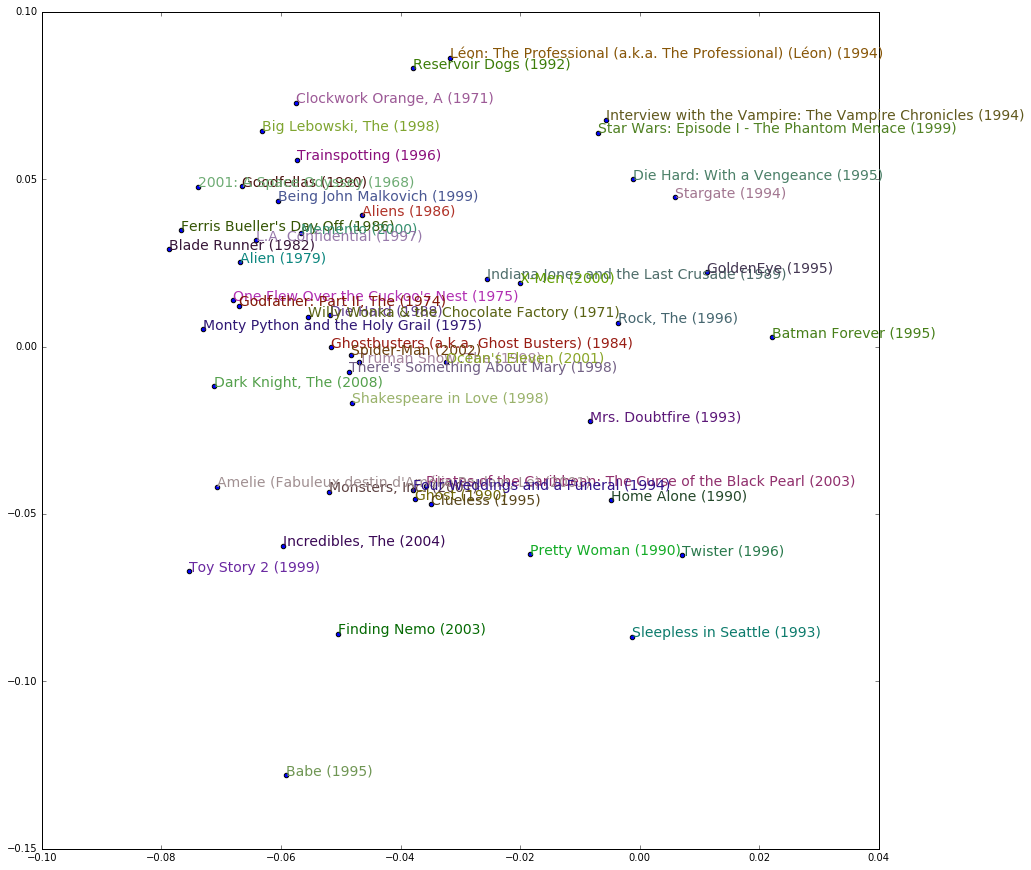

In [410]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [63]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [64]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [65]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79838 samples, validate on 20166 samples
Epoch 1/8
79838/79838 [==============================] - 2s - loss: 2.5208 - val_loss: 0.8969
Epoch 2/8
79838/79838 [==============================] - 2s - loss: 1.4826 - val_loss: 0.8493
Epoch 3/8
79838/79838 [==============================] - 2s - loss: 1.2283 - val_loss: 0.8461
Epoch 4/8
79838/79838 [==============================] - 2s - loss: 1.0386 - val_loss: 0.8128
Epoch 5/8
79838/79838 [==============================] - 2s - loss: 0.9115 - val_loss: 0.8000
Epoch 6/8
79838/79838 [==============================] - 2s - loss: 0.8452 - val_loss: 0.7966
Epoch 7/8
79838/79838 [==============================] - 2s - loss: 0.8179 - val_loss: 0.7938
Epoch 8/8
79838/79838 [==============================] - 2s - loss: 0.8030 - val_loss: 0.7943


This improves on our already impressive accuracy even further!